## Calculate marine biomes with CESM2 using the method outlined in Fay & McKinley 2014

In [1]:
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools 
from statistics import mean
from matplotlib import style
from scipy import stats

### Get grid info: we need a land/ocean mask, lats, lons, and major basin masks

In [2]:
### First, get the pop grid information, so we have lon, lat
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG

In [3]:
### Second, create an empty ones array on the model grid
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))

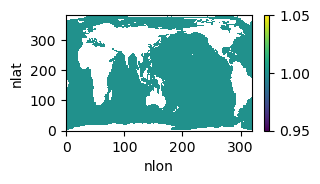

In [4]:
### third, use the REGION_MASK variable and the ones array to create a land mask
ones = ones.where(ds_grid.REGION_MASK>0)
ones.plot(figsize=(3,1.5))

In [5]:
### forth, get the major basins mask 
major_basins = xr.open_dataset('/glade/work/kristenk/ocean_masks/major_basins.nc')

major_basins = major_basins.basin.values
major_basins = xr.DataArray(major_basins, dims=('nlat','nlon'))

### Get the model FOSI run

In [6]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'

In [7]:
variables = ['IFRAC','HMXL','diatChl','spChl','coccoChl','diazChl','TEMP']

In [8]:
def preprocess(ds):
    ds = ds.isel(z_t=0)
    ds = ds.isel(z_t_150m=0)
    return ds

In [9]:
ds_fosi = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess, combine='nested')

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time','KMT'] + [var]

    ds_tmp = ds_tmp.drop_vars([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi = xr.merge([ds_fosi,ds_tmp])

starting on  IFRAC
starting on  HMXL
starting on  diatChl
starting on  spChl
starting on  coccoChl
starting on  diazChl
starting on  TEMP


### Spin up Dask

In [10]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        account='P93300070',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client



In [11]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.175:46543,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Make a mean of the time bounds (CESM-specific)

In [12]:
ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

### trim to the satellite period since 2003

In [13]:
ds_fosi.time[540:768]

<xarray.DataArray 'time' (time: 228)>
array([cftime.DatetimeNoLeap(2003, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2003, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2003, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2021, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2021, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2021, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time      (time) object 2003-01-16 12:00:00 ... 2021-12-16 12:00:00
    z_t       float32 500.0
    z_t_150m  float32 500.0

In [14]:
### slice the data
ds_fosi = ds_fosi.isel(time=slice(540,768))

### Sum up chlorophyll from each phytoplankton type

In [15]:
ds_fosi['Chl']=(ds_fosi['diatChl'] + ds_fosi['spChl'] + ds_fosi['coccoChl'] + ds_fosi['diazChl'])

### Drop unnecessary variables

In [16]:
ds_fosi = ds_fosi.drop_vars(['diatChl','spChl','coccoChl','diazChl','KMT','z_t','z_t_150m','dz'])

### Generate monthly climatology of ice fraction, max MLD, SST, and Chl

In [17]:
ds_clim = ds_fosi.groupby('time.month').mean('time')
ds_clim

<xarray.Dataset>
Dimensions:  (month: 12, nlat: 384, nlon: 320)
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    IFRAC    (month, nlat, nlon) float32 dask.array<chunksize=(12, 124, 104), meta=np.ndarray>
    HMXL     (month, nlat, nlon) float32 dask.array<chunksize=(12, 124, 104), meta=np.ndarray>
    TEMP     (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    Chl      (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

### First step from the FM2014 Methods is this (but this is not described further), we will use major basins mask:
"The global open ocean is first divided into ocean basins (Atlantic, Pacific, Indian, and Southern Ocean)"

### The next step is applying criteria in Table 1 of FM2014:
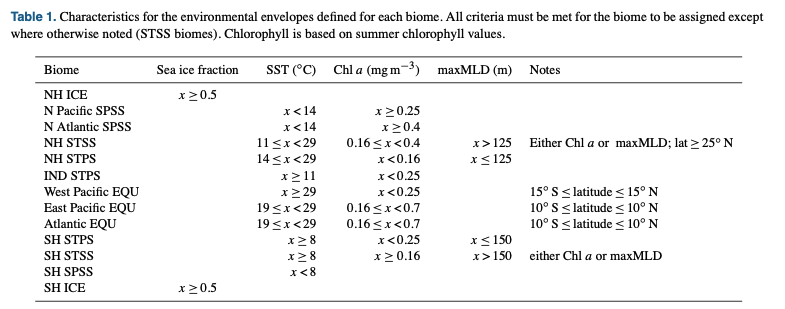

### Also important: 
Biome assignments are made from pole to Equator for each hemisphere, beginning with the Northern Hemisphere (NH). This order is important as some biome’s criteria are not mutually exclusive (specifically the EQU and South Pacific and Atlantic STPS biomes).


### Create an empty BIOME dataset, each biome will be a variable:
• 1 = within biome

• 0 = outside biome

• Nan on land

In [18]:
ds_biome = xr.Dataset()

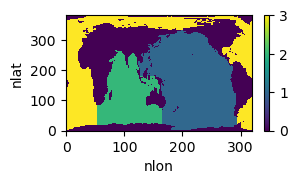

In [19]:
major_basins.plot(figsize=(3,1.5))

# A few precalculations....

### Figure out how to split up basins

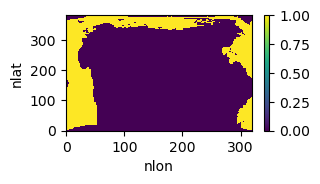

In [20]:
Atlantic = ones.where(major_basins == 3, other=0)
#.where(major_basins.basin == 3) #ones.where(ds_grid.REGION_MASK >= 5, other=0).where(ds_grid.REGION_MASK<10, other=0)
Atlantic.plot(figsize=(3,1.5))

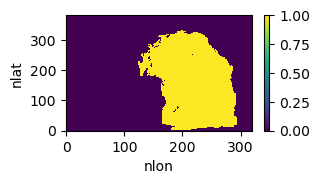

In [21]:
Pacific = ones.where(major_basins == 1, other=0)
Pacific.plot(figsize=(3,1.5))

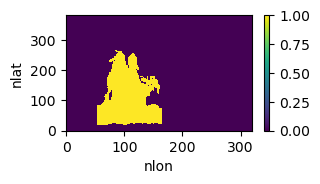

In [22]:
Indian = ones.where(major_basins == 2, other=0)
Indian.plot(figsize=(3,1.5))

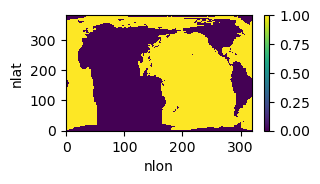

In [23]:
Atlantic_Pacific = Atlantic + Pacific
Atlantic_Pacific.plot(figsize=(3,1.5))

### Compute mean NH "spring/summer" chlorophyll concentration: April - September, all areas north of 10°S

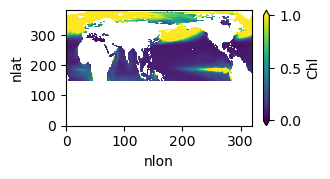

In [24]:
chl_NH_field = ds_clim.Chl.isel(month=slice(3,9)).mean(dim='month').where(lats > -10)
chl_NH_field.plot(vmin=0,vmax=1,figsize=(3,1.5))

### Compute SH spring/summer chl field: December to March, all regions south of 10°S

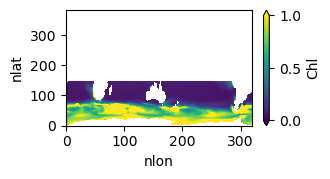

In [25]:
chl_SH_field = (ds_clim.Chl.isel(month=11) + ds_clim.Chl.isel(month=0) + ds_clim.Chl.isel(month=1) + ds_clim.Chl.isel(month=2)) / 4.
chl_SH_field = chl_SH_field.where(ds_grid.REGION_MASK > 0).where(lats <= -10)
chl_SH_field.plot(vmin=0,vmax=1, figsize=(3,1.5))

### Combine NH and SH chlorophyll fields so we can have just one for masking

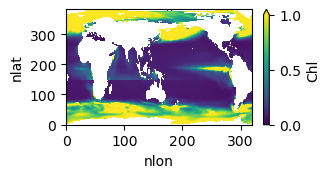

In [26]:
tmp1 = chl_NH_field.where(chl_NH_field > 0, other=0)
tmp2 = chl_SH_field.where(chl_SH_field > 0, other=0)

chl = (tmp1 + tmp2).where(ds_grid.REGION_MASK > 0)
chl.plot(vmin=0,vmax=1, figsize=(3,1.5))

### Compute SST field for masking. I think it's just annual mean, based on this sentence:

"For mean SST and sea ice fraction criteria, annual climatologies for years 1998–2010 are averaged. Specific criteria for each biome are presented in Table 1."

In [27]:
sst = ds_clim.TEMP.mean(dim='month')

### Compute max of the maxMLD to use for masking

In [28]:
mld = ds_clim.HMXL.max(dim='month') * 0.01 ### covert to m!

### Compute maximum ice fraction over the course of the year

In [29]:
ice = ds_clim.IFRAC.max(dim='month')

### Important thresholds

In [30]:
### SST threholds
SPSS_NH_temp_upthres = 14

STSS_NH_temp_lothres = 11
STSS_NH_temp_upthres = 29

STPS_NH_temp_lothres = 14
STPS_NH_temp_upthres = 29

STPS_Ind_temp_lothres = 11

WPacEq_temp_lothres = 29
EPacEq_temp_lothres = 19
EPacEq_temp_upthres = 29
AtlEq_temp_lothres = 19
AtlEq_temp_upthres = 29

SPSS_SH_temp_upthres = 8
STSS_SH_temp_lothres = 8
STPS_SH_temp_lothres = 8

In [31]:
### Chl thresholds
SPSS_NPac_chl_lothres = 0.25
SPSS_NAtl_chl_lothres = 0.4

STSS_NH_chl_lothres = 0.16
STSS_NH_chl_upthres = 0.4

STPS_NH_chl_upthres = 0.16

STPS_Ind_chl_upthres = 0.25

WPacEq_chl_upthres = 0.25
EPacEq_chl_lothres = 0.16
EPacEq_chl_upthres = 0.7
AtlEq_chl_lothres = 0.16
AtlEq_chl_upthres = 0.7

STSS_SH_chl_lothres = 0.16

STPS_SH_chl_upthres = 0.25

In [32]:
### maxMLD thresholds

STSS_NH_mld_lothres = 125

STPS_NH_mld_upthres = 125

STSS_SH_mld_lothres = 150

STPS_SH_mld_upthres = 150

In [33]:
### ice thresholds

ICE_lothres = 0.5

# BIOME ASSIGNMENTS

### NH ICE biome

"A minimum threshold of 0.5 fractional cover- age in any month of the year designates the ICE biome."

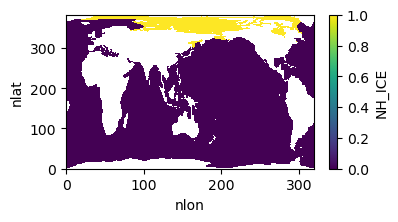

In [34]:
ds_biome['NH_ICE'] = ones.where(ice > ICE_lothres).where(lats > 0)

ds_biome['NH_ICE'] = ds_biome['NH_ICE'].where(ds_biome['NH_ICE'] > 0, other = 0)

ds_biome['NH_ICE'] = ds_biome['NH_ICE'].where(ones > 0).compute()

ds_biome['NH_ICE'].plot(figsize=(4,2))

### SPSS NH biomes: Alantic and Pacific

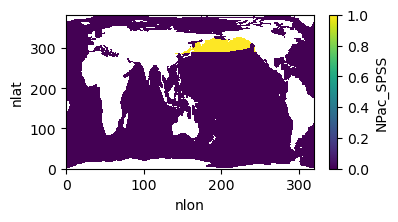

In [35]:
ds_biome['NPac_SPSS'] = ones.where(sst < SPSS_NH_temp_upthres).where(chl >= SPSS_NPac_chl_lothres).where(Pacific == 1).where(lats > 0)

### Lastly, make sure it doesn't conflict with the NH ICE BIOME
ds_biome['NPac_SPSS'] = ds_biome['NPac_SPSS'].where(ds_biome['NH_ICE'] < 1)

ds_biome['NPac_SPSS'] = ds_biome['NPac_SPSS'].where(ds_biome['NPac_SPSS'] > 0, other = 0)

ds_biome['NPac_SPSS'] = ds_biome['NPac_SPSS'].where(ones > 0).compute()

ds_biome['NPac_SPSS'].plot(figsize=(4,2))

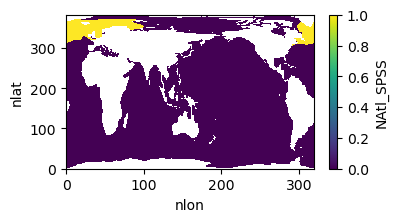

In [36]:
ds_biome['NAtl_SPSS'] = ones.where(sst < SPSS_NH_temp_upthres).where(chl >= SPSS_NAtl_chl_lothres).where(Atlantic == 1).where(lats > 0)

### Lastly, make sure it doesn't conflict with the NH ICE BIOME
ds_biome['NAtl_SPSS'] = ds_biome['NAtl_SPSS'].where(ds_biome['NH_ICE'] < 1)

ds_biome['NAtl_SPSS'] = ds_biome['NAtl_SPSS'].where(ds_biome['NAtl_SPSS'] > 0, other = 0)

ds_biome['NAtl_SPSS'] = ds_biome['NAtl_SPSS'].where(ones > 0).compute()

ds_biome['NAtl_SPSS'].plot(figsize=(4,2))

### Northern hemisphere Subtropical Seasonally Stratified (NH STSS)

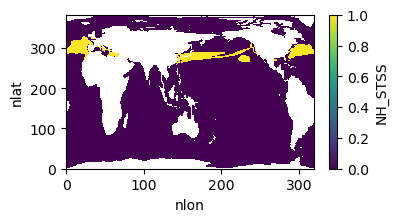

In [37]:
ds_biome['NH_STSS'] = ones.where(sst >= STSS_NH_temp_lothres).where(sst < STSS_NH_temp_upthres).where(lats > 25)

##### only one of two criteria for Chl and MLD must be met, so do it like this:
tmp = ds_biome['NH_STSS'].where(chl >= STSS_NH_chl_lothres).where(chl < STSS_NH_chl_upthres)
tmp = tmp.where(tmp > 0, other = 0)
tmp2 = ds_biome['NH_STSS'].where(mld > STSS_NH_mld_lothres)
tmp2 = tmp2.where(tmp2 > 0, other = 0)
tmp3 = (tmp + tmp2)
ds_biome['NH_STSS'] = ones.where(tmp3 >= 1)

### now make sure it doesn't overlap with SPSS biomes to the north
ds_biome['NH_STSS'] = ds_biome['NH_STSS'].where(ds_biome.NPac_SPSS < 1).where(ds_biome.NAtl_SPSS < 1)

ds_biome['NH_STSS'] = ds_biome['NH_STSS'].where(ds_biome['NH_STSS'] > 0, other = 0).where(ones > 0).compute()

ds_biome['NH_STSS'].plot(figsize=(4,2))

### Northern hemisphere Subtropical Permanently stratified (NH STPS) 

### (Atlantic and Pacific included, Indian is separate)

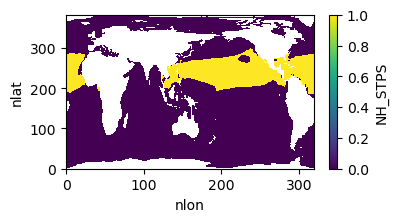

In [38]:
ds_biome['NH_STPS'] = ones.where(sst >= STPS_NH_temp_lothres).where(sst < STPS_NH_temp_upthres).where(lats > 0).where(Atlantic_Pacific == 1)

ds_biome['NH_STPS'] = ds_biome['NH_STPS'].where(chl < STPS_NH_chl_upthres)

ds_biome['NH_STPS'] = ds_biome['NH_STPS'].where(mld <= STPS_NH_mld_upthres)

### now make sure it doesn't overlap with STSS biome to the north
ds_biome['NH_STPS'] = ds_biome['NH_STPS'].where(ds_biome.NH_STSS < 1)

ds_biome['NH_STPS'] = ds_biome['NH_STPS'].where(ds_biome['NH_STPS'] > 0, other = 0) 

ds_biome['NH_STPS'] = ds_biome['NH_STPS'].where(ones > 0).compute()

ds_biome['NH_STPS'].plot(figsize=(4,2))

### Indian Subtropical Permanently stratified (IND STPS)

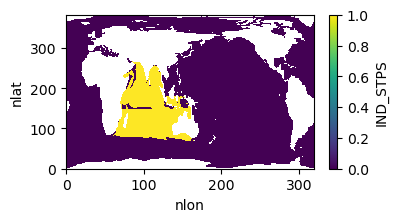

In [39]:
ds_biome['IND_STPS'] = ones.where(sst >= STPS_Ind_temp_lothres).where(chl < STPS_Ind_chl_upthres).where(Indian == 1)

ds_biome['IND_STPS'] = ds_biome['IND_STPS'].where(ds_biome['IND_STPS'] > 0, other = 0)

ds_biome['IND_STPS'] = ds_biome['IND_STPS'].where(ones > 0).compute()
                                               
ds_biome['IND_STPS'].plot(figsize=(4,2))

### West Pacific Equatorial regions (WPac_EQ)

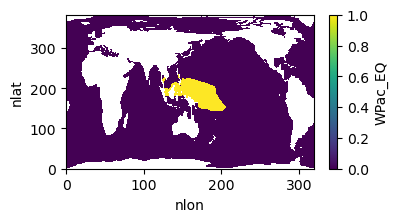

In [40]:
ds_biome['WPac_EQ'] = ones.where(sst > WPacEq_temp_lothres).where(lats >= -15).where(lats <= 15).where(Pacific == 1)
ds_biome['WPac_EQ'] = ds_biome['WPac_EQ'].where(chl < WPacEq_chl_upthres)

### Lastly, make sure it doesn't conflict with biome to the north
ds_biome['WPac_EQ'] = ds_biome['WPac_EQ'].where(ds_biome['NH_STPS'] < 1)

ds_biome['WPac_EQ'] = ds_biome['WPac_EQ'].where(ds_biome['WPac_EQ'] > 0, other = 0)

ds_biome['WPac_EQ'] = ds_biome['WPac_EQ'].where(ones > 0).compute()

ds_biome['WPac_EQ'].plot(figsize=(4,2))

### Eastern Pacific Equatorial region (EPac_EQ)

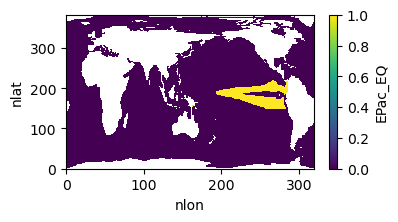

In [41]:
ds_biome['EPac_EQ'] = ones.where(sst >= EPacEq_temp_lothres).where(sst < EPacEq_temp_upthres).where(lats >= -10).where(lats <= 10).where(Pacific == 1)
ds_biome['EPac_EQ'] = ds_biome['EPac_EQ'].where(chl >= EPacEq_chl_lothres).where(chl < EPacEq_chl_upthres)

### Lastly, make sure it doesn't conflict with biome to the north
ds_biome['EPac_EQ'] = ds_biome['EPac_EQ'].where(ds_biome['NH_STPS'] < 1)

ds_biome['EPac_EQ'] = ds_biome['EPac_EQ'].where(ds_biome['EPac_EQ'] > 0, other = 0)

ds_biome['EPac_EQ'] = ds_biome['EPac_EQ'].where(ones > 0).compute()

ds_biome['EPac_EQ'].plot(figsize=(4,2))

### Equatorial Atlantic (Atl_EQ)

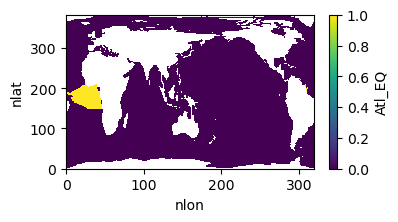

In [42]:
ds_biome['Atl_EQ'] = ones.where(sst >= AtlEq_temp_lothres).where(sst < AtlEq_temp_upthres).where(lats >= -10).where(lats <= 10).where(Atlantic == 1)
ds_biome['Atl_EQ'] = ds_biome['Atl_EQ'].where(chl >= AtlEq_chl_lothres).where(chl < AtlEq_chl_upthres)

### Lastly, make sure it doesn't conflict with biome to the north
ds_biome['Atl_EQ'] = ds_biome['Atl_EQ'].where(ds_biome['NH_STPS'] < 1)

ds_biome['Atl_EQ'] = ds_biome['Atl_EQ'].where(ds_biome['Atl_EQ'] > 0, other = 0)

ds_biome['Atl_EQ'] = ds_biome['Atl_EQ'].where(ones > 0).compute()

ds_biome['Atl_EQ'].plot(figsize=(4,2))

### Southern hemisphere ICE biome (SH ICE)

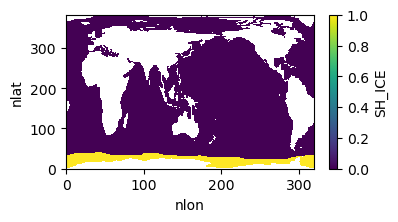

In [43]:
ds_biome['SH_ICE'] = ones.where(ice > ICE_lothres).where(lats < 0)

ds_biome['SH_ICE'] = ds_biome['SH_ICE'].where(ds_biome['SH_ICE'] > 0, other = 0)

ds_biome['SH_ICE'] = ds_biome['SH_ICE'].where(ones > 0).compute()

ds_biome['SH_ICE'].plot(figsize=(4,2))

### Southern hemisphere Subpolar seasonally stratified (SH SPSS)

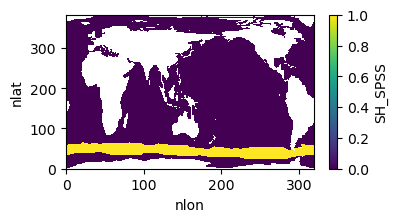

In [44]:
ds_biome['SH_SPSS'] = ones.where(sst < SPSS_SH_temp_upthres).where(lats < 0)

### Lastly, make sure it doesn't conflict with the SH ICE BIOME
ds_biome['SH_SPSS'] = ds_biome['SH_SPSS'].where(ds_biome['SH_ICE'] < 1)

ds_biome['SH_SPSS'] = ds_biome['SH_SPSS'].where(ds_biome['SH_SPSS'] > 0, other = 0)

ds_biome['SH_SPSS'] = ds_biome['SH_SPSS'].where(ones > 0).compute()

ds_biome['SH_SPSS'].plot(figsize=(4,2))

### Southern hemisphere Subtropical Seasonally Stratified (SH STSS)

#### I added that this one has to be south of 25°S (like the NH STSS has to be north of 25°N), otherwise this one extends to the equatorial regions

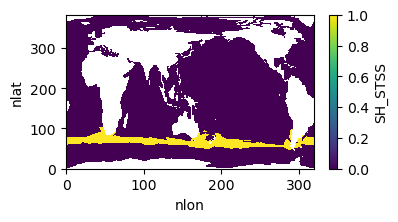

In [45]:
ds_biome['SH_STSS'] = ones.where(sst >= STSS_SH_temp_lothres).where(lats <= -25)

##### only one of two criteria for Chl and MLD must be met, so do it like this:
tmp = ds_biome['SH_STSS'].where(chl >= STSS_SH_chl_lothres)
tmp = tmp.where(tmp > 0, other = 0)
tmp2 = ds_biome['SH_STSS'].where(mld > STSS_SH_mld_lothres)
tmp2 = tmp2.where(tmp2 > 0, other = 0)
tmp3 = (tmp + tmp2)
ds_biome['SH_STSS'] = ones.where(tmp3 >= 1)

### now make sure it doesn't overlap with SPSS biomes to the north
ds_biome['SH_STSS'] = ds_biome['SH_STSS'].where(ds_biome.SH_SPSS < 1).where(ds_biome.NAtl_SPSS < 1).where(ds_biome.IND_STPS < 1)

ds_biome['SH_STSS'] = ds_biome['SH_STSS'].where(ds_biome['SH_STSS'] > 0, other = 0).where(ones > 0).compute()

ds_biome['SH_STSS'].plot(figsize=(4,2))

### Southern hemisphere subtropical permanently stratified (STPS)

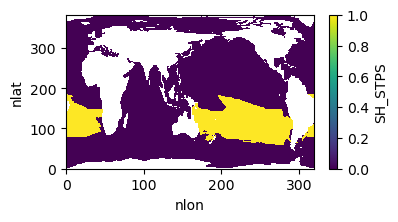

In [46]:
ds_biome['SH_STPS'] = ones.where(sst >= STPS_SH_temp_lothres).where(lats < 0)

ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(chl < STPS_SH_chl_upthres)

ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(mld <= STPS_SH_mld_upthres)

### now make sure it doesn't overlap with STSS biome to the south AND the Equatorial biomes to the north AND the Indian STPS
ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(ds_biome.SH_STSS < 1)
ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(ds_biome.Atl_EQ < 1).where(ds_biome.EPac_EQ < 1).where(ds_biome.WPac_EQ < 1)
ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(ds_biome.IND_STPS < 1)

ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(ds_biome['SH_STPS'] > 0, other = 0) 

ds_biome['SH_STPS'] = ds_biome['SH_STPS'].where(ones > 0).compute()

ds_biome['SH_STPS'].plot(figsize=(4,2))

### Add up all biomes make sure that they are not overlapping

In [47]:
%%time

ds_biome = ds_biome.load()

CPU times: user 12.5 ms, sys: 3.47 ms, total: 16 ms
Wall time: 37 ms


In [48]:
biomes = ['NH_ICE','NPac_SPSS','NAtl_SPSS',
          'NH_STSS','NH_STPS','IND_STPS','WPac_EQ',
          'EPac_EQ','Atl_EQ','SH_ICE','SH_SPSS','SH_STSS',
          'SH_STPS']

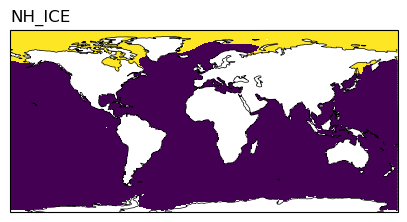

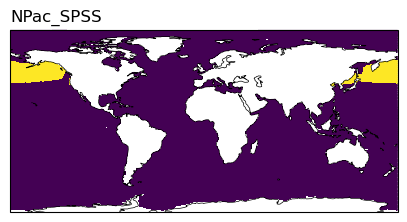

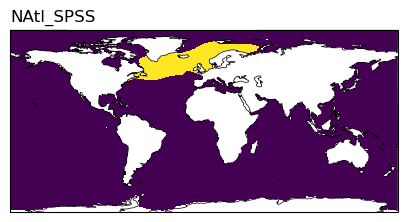

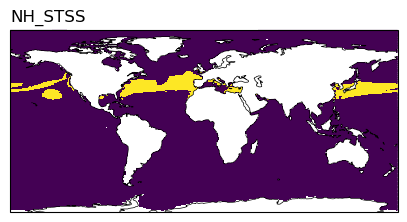

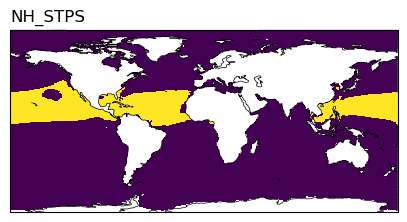

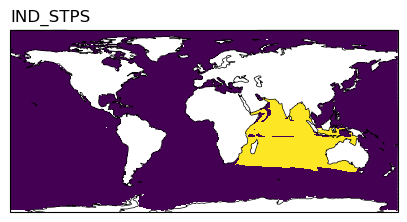

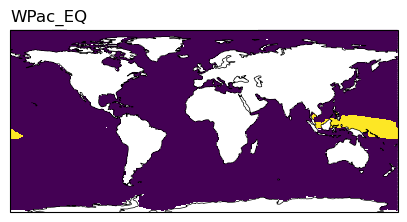

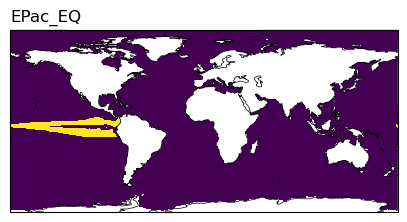

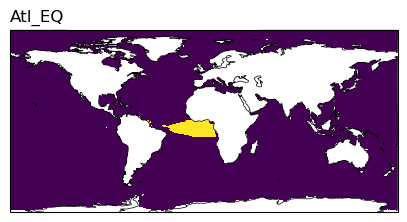

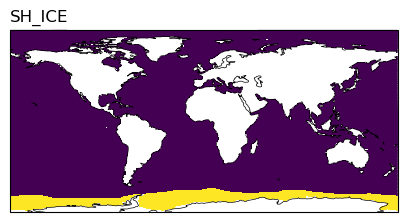

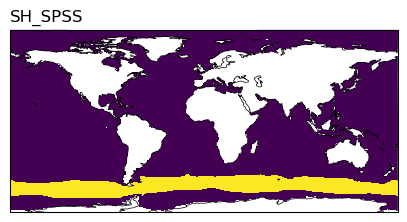

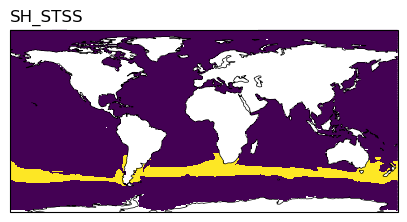

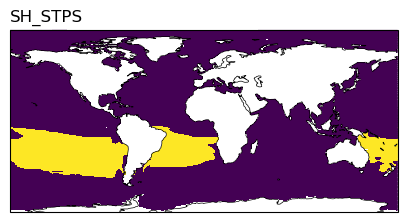

In [49]:
i = 0

for biome in biomes:
    if i == 0:
        biome_tot = ds_biome[biome]
    else:
        biome_tot = biome_tot + ds_biome[biome]

    fig = plt.figure(figsize=(5,2.5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    ax.set_title(biome, fontsize=12, loc='left')
    pc1=ax.pcolormesh(lons, lats, ds_biome[biome], cmap='viridis',
                      transform=ccrs.PlateCarree())

    plt.show()
    
    i = i + 1

### After several iterations (corrections) now each gridcell is only assigned to one biome

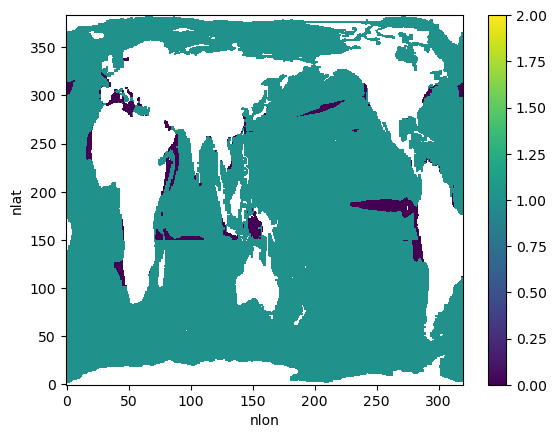

In [50]:
biome_tot.plot()

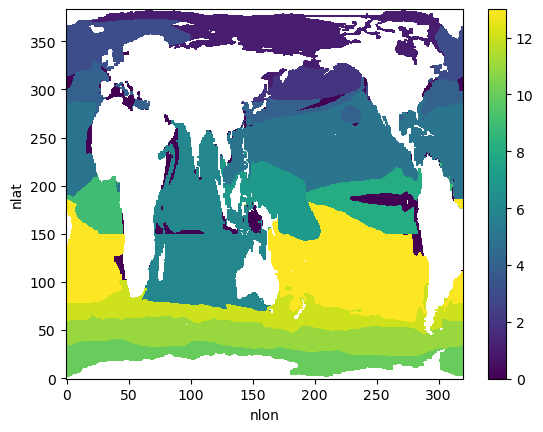

In [51]:
zeros = np.full((384,320),0,dtype=float)
zeros = xr.DataArray(zeros,dims=('nlat','nlon'))
zeros = zeros.where(ds_grid.REGION_MASK>0)

all_biomes = zeros

i = 1

for biome in biomes:
    all_biomes = (zeros + i).where(ds_biome[biome]==1,other=all_biomes)
    
    i = i + 1
    
all_biomes.plot()

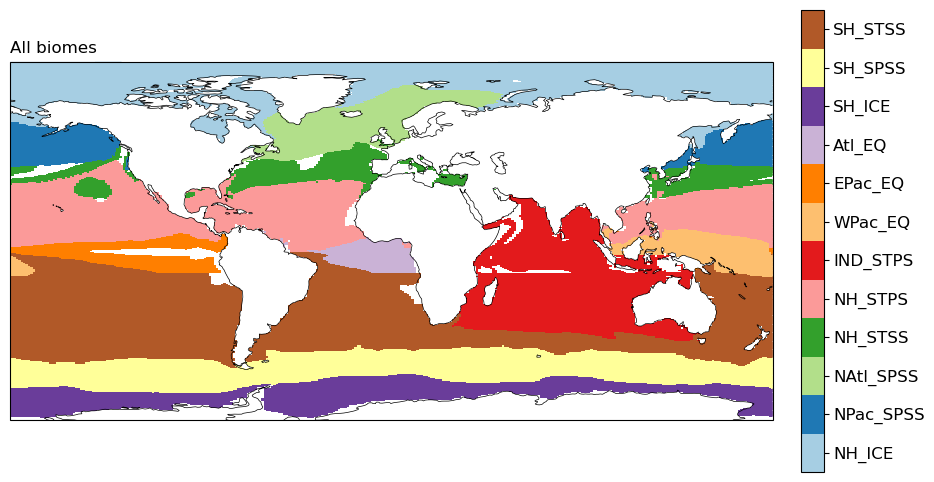

In [52]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('All biomes', fontsize=12, loc='left')
pc1=ax.pcolormesh(lons, lats, all_biomes.where(all_biomes>0), cmap='Paired',
                  transform=ccrs.PlateCarree())
#pci=ax.contourf(lons, lats, all_biomes.where(all_biomes==0),levels=[0,0.99],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar = fig.colorbar(pc1, ticks=np.arange(1.5,14,1), pad=0.03)
cbar.ax.set_yticklabels(biomes, fontsize=12) ;